In [1]:
import os

import pandas as pd
import rdkit
from rdkit import Chem

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from collections import Counter

from scipy import stats

from rdkit.Chem.Descriptors import ExactMolWt

RDKit WARNING: [09:52:28] Enabling RDKit 2019.09.3 jupyter extensions


In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
def getmol(x):
    try:
        mol = Chem.MolFromSmiles(x)
        return mol
    except:
        return None
    
def getinchi(x):
    try:
        mol = Chem.MolFromSmiles(x)
        return Chem.MolToInchi(mol)
    except:
        return None

def getRB(x):
    try:
        mol = Chem.MolFromSmiles(x)
        return rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    except:
        return None

def getMW(x):
    try:
        mol = Chem.MolFromSmiles(x)
        return ExactMolWt(mol)
    except:
        return None
    
def r2(x, y):
    #print(stats.pearsonr(x, y)[0])
    return stats.pearsonr(x, y)[0] ** 2

def getEle(smilist):
    eles = set()
    for smi in smilist:
        mol = Chem.MolFromSmiles(smi)
        elelist = list(Counter(atom.GetSymbol() for atom in mol.GetAtoms()).keys())
        for ele in elelist:
            #for e in ele:
            eles.add(ele)
    return eles

def filterdf(smilist):
    filters = []
    for smi in smilist:
        mol = Chem.MolFromSmiles(smi)
        elelist = list(Counter(atom.GetSymbol() for atom in mol.GetAtoms()).keys())
        for ele in elelist:
            if ele in ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H']:
                temp = True
            else:
                temp = False
                break
        filters.append(temp)
    return filters

def addInfo(df):
    assert 'SMILES' in list(df.columns)
    df['Mol'] = df['SMILES'].apply(lambda x: getmol(x))
    df = df[~pd.isnull(df['Mol'])].reset_index(drop=True)
    
    df['InChI'] = df['SMILES'].apply(lambda x: getinchi(x))
    df['RB'] = df['SMILES'].apply(lambda x: getRB(x))
    df['MW'] = df['SMILES'].apply(lambda x: getMW(x))
    ele_ = getEle(df['SMILES'])
    
    return df, ele_

def getStats(df):
    return df.describe().loc[['mean','std', 'min', 'max']]

def getFigs(df, properName, save=False, savepath=None, savename=None):
    f1 = plt.figure(figsize=(10,10))
    ax1 = f1.add_subplot(111)
    sns.distplot(df[properName], ax=ax1)
    ax1.set_xlabel(properName, fontsize=25)
    ax1.set_ylabel('Density', fontsize=25)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax1.xaxis.labelpad = 20
    plt.tight_layout()
    if save:
        f1.savefig(os.path.join(savepath, savename), format='svg', dpi=1200)

def group(df, identifier):
    df1 = df.groupby(identifier).mean()
    df1['InChI'] = df1.index
    df1['SMILES'] = df.groupby(identifier).max()['SMILES']
    df1.index = range(df1.shape[0])
    return df1

### Minnesota Database 
###

In [3]:
minne = pd.read_csv('../MNSol_all_rev.csv')

In [90]:
minne_use = minne[(minne['Solvent'] == 'octanol') & (minne['Charge'] == 0)][['FileHandle', 'SoluteName',  'Smiles', 'DeltaGsolv']].reset_index(drop=True)


In [91]:
minne_use.shape

(247, 4)

In [92]:
minne_use = minne_use.rename(columns={'Smiles': 'SMILES', 'DeltaGsolv': 'Sol'})

In [93]:
minne_use1, eleDis = addInfo(minne_use)

In [87]:
eleDis

{'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si'}

In [94]:
minne_use1.shape

(246, 8)

In [79]:
minne_use1.to_csv('./solvation_oct_exp.csv', index=False)

In [10]:
len(set(minne_use1['InChI']))

246

In [11]:
minne_use1.head()

,FileHandle,SoluteName,SMILES,Sol,Mol,InChI,RB,MW
0,0008noc,n-octane,C(CCCC)CCC,-4.18,<rdkit.Chem.rdchem.Mol object at 0x1a222792b0>,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",5,114.140851
1,0036tol,toluene,c1cc(ccc1)C,-4.55,<rdkit.Chem.rdchem.Mol object at 0x1a222795d0>,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3",0,92.062600
2,0045eth,ethanol,OCC,-4.36,<rdkit.Chem.rdchem.Mol object at 0x1a22279620>,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",0,46.041865
3,0062dio,"1,4-dioxane",C1COCCO1,-4.89,<rdkit.Chem.rdchem.Mol object at 0x1a22279670>,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,0,88.052429
4,0076but,2-butanone,CCC(=O)C,-3.78,<rdkit.Chem.rdchem.Mol object at 0x1a222796c0>,"InChI=1S/C4H8O/c1-3-4(2)5/h3H2,1-2H3",1,72.057515


In [13]:
gas = np.load('./gas_opt_log.npy')
octa = np.load('./oct_smd_log.npy')

In [15]:
df_gas = pd.DataFrame([i for i in gas], columns=['enerGas', 'Time', 'ID'])
df_oct = pd.DataFrame([i for i in octa], columns=['enerOct', 'Time', 'ID'])

In [16]:
df_gas.shape, df_oct.shape

((66105, 3), (65085, 3))

In [18]:
df_gas_use = df_gas[~pd.isnull(df_gas['enerGas'])].reset_index(drop=True)
df_gas_use['enerGas'] = df_gas_use['enerGas'].astype(float)
df_oct_use = df_oct[~pd.isnull(df_oct['enerOct'])].reset_index(drop=True)
df_oct_use['enerOct'] = df_oct_use['enerOct'].astype(float)

In [19]:
df_gas_group = df_gas_use.groupby('ID').min()
df_gas_group['ID'] = df_gas_group.index
df_gas_group.index = range(df_gas_group.shape[0])

In [22]:
df_oct_group = df_oct_use.groupby('ID').min()
df_oct_group['ID'] = df_oct_group.index
df_oct_group.index = range(df_oct_group.shape[0])
df_oct_group['ID'] = df_oct_group['ID'].astype(float)

In [23]:
gasOct = df_gas_group.merge(df_oct_group, on='ID', how='inner')

In [25]:
gasOct['CalcSol'] = 627.509*(gasOct['enerOct'].astype(float) - gasOct['enerGas'].astype(float))


In [26]:
gasOct.shape

(1428, 6)

In [29]:
solvation_old = pd.read_csv('./solvation_processed.csv')

In [28]:
gasOct.head()

,enerGas,Time_x,ID,enerOct,Time_y,CalcSol
0,-613.979557,1425.7,0.0,-613.995444,185.8,-9.969735
1,-594.084153,1519.9,1.0,-594.097688,196.2,-8.493551
2,-1559.887943,2.0,2.0,-1559.903539,371.2,-9.786317
3,-464.719491,1454.5,3.0,-464.731798,187.2,-7.722728
4,-468.352788,1293.3,4.0,-468.364757,188.1,-7.510363


In [30]:
solvation_old.head()

,SMILES,InChI,SolEnergy
0,CCCOC(=O)c1ccc(O)cc1,InChI=1S/C10H12O3/c1-2-7-13-10(12)8-3-5-9(11)6...,-9.370000
1,CCOc1ccc(N=C(C)O)cc1,InChI=1S/C10H13NO2/c1-3-13-10-6-4-9(5-7-10)11-...,-10.944049
2,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1,"InChI=1S/C10H14NO5PS/c1-3-14-17(18,15-4-2)16-1...",-6.717396
3,CC(C)(C)c1ccc(O)cc1,"InChI=1S/C10H14O/c1-10(2,3)8-4-6-9(11)7-5-8/h4...",-5.892801
4,CCCCCCCCC(C)=O,InChI=1S/C10H20O/c1-3-4-5-6-7-8-9-10(2)11/h3-9...,-2.212438


In [31]:
#expSolDF = []
#sourcesDF = []
inchisDF = []
for i in gasOct['ID'].tolist():
    #expSolDF.append(expSol[int(i)])
    #sourcesDF.append(sources[int(i)])
    inchisDF.append(solvation_old['InChI'][int(i)])

In [33]:
#gasOct['expSol'] = expSolDF
#gasOct['sources'] = sourcesDF
gasOct['InChI'] = inchisDF

In [35]:
gasOct.head()

,enerGas,Time_x,ID,enerOct,Time_y,CalcSol,InChI
0,-613.979557,1425.7,0.0,-613.995444,185.8,-9.969735,InChI=1S/C10H12O3/c1-2-7-13-10(12)8-3-5-9(11)6...
1,-594.084153,1519.9,1.0,-594.097688,196.2,-8.493551,InChI=1S/C10H13NO2/c1-3-13-10-6-4-9(5-7-10)11-...
2,-1559.887943,2.0,2.0,-1559.903539,371.2,-9.786317,"InChI=1S/C10H14NO5PS/c1-3-14-17(18,15-4-2)16-1..."
3,-464.719491,1454.5,3.0,-464.731798,187.2,-7.722728,"InChI=1S/C10H14O/c1-10(2,3)8-4-6-9(11)7-5-8/h4..."
4,-468.352788,1293.3,4.0,-468.364757,188.1,-7.510363,InChI=1S/C10H20O/c1-3-4-5-6-7-8-9-10(2)11/h3-9...


In [67]:
gasOct_use = gasOct[['InChI', 'CalcSol', 'Time_x', 'Time_y']]

Make ups

In [47]:
makeups_gas = np.load('./makeups_gas_opt_log.npy')
dfMakeup_gas = pd.DataFrame([i for i in makeups_gas], columns=['enerGas', 'Time', 'ID'])
dfMakeup_gas_use = dfMakeup_gas[~pd.isnull(dfMakeup_gas['enerGas'])].reset_index(drop=True)
dfMakeup_gas_use['enerGas'] = dfMakeup_gas_use['enerGas'].astype(float)

In [48]:
dfMakeup_gas_group = dfMakeup_gas_use.groupby('ID').min()
dfMakeup_gas_group['ID'] = dfMakeup_gas_group.index
dfMakeup_gas_group.index = range(dfMakeup_gas_group.shape[0])

In [49]:
makeups_oct = np.load('./makeups_oct_opt_log.npy')
dfMakeup_oct = pd.DataFrame([i for i in makeups_oct], columns=['enerOct', 'Time', 'ID'])
dfMakeup_oct_use = dfMakeup_oct[~pd.isnull(dfMakeup_oct['enerOct'])].reset_index(drop=True)
dfMakeup_oct_use['enerOct'] = dfMakeup_oct_use['enerOct'].astype(float)

In [51]:
dfMakeup_oct_group = dfMakeup_oct_use.groupby('ID').min()
dfMakeup_oct_group['ID'] = dfMakeup_oct_group.index
dfMakeup_oct_group.index = range(dfMakeup_oct_group.shape[0])

In [57]:
Makeup_gasOct = dfMakeup_gas_group.merge(dfMakeup_oct_group, on='ID', how='inner')

In [58]:
Makeup_gasOct.shape

(108, 5)

In [59]:
Makeup_gasOct.head()

,enerGas,Time_x,ID,enerOct,Time_y
0,-1915.968185,7.1,1.0,-1915.987878,305.9
1,-1916.516335,1.7,2.0,-1916.534003,447.6
2,-2275.113035,33.6,3.0,-2275.130400,404.4
3,-1560.418668,43.1,4.0,-1560.434586,445.1
4,-1064.509496,0.9,5.0,-1064.531058,269.5


In [60]:
Makeup_gasOct['CalcSol'] = 627.509*(Makeup_gasOct['enerOct'].astype(float) - Makeup_gasOct['enerGas'].astype(float))



In [62]:
dfMakeup = pd.read_csv('./solvation_makeup.csv')

In [63]:
Makeup_inchi = []
Makeup_smi = []
for id_ in Makeup_gasOct['ID']:
    Makeup_inchi.append(dfMakeup['InChI'].tolist()[int(id_)])
    Makeup_smi.append(dfMakeup['SMILES'].tolist()[int(id_)])

In [65]:
Makeup_gasOct['SMILES'] = Makeup_smi
Makeup_gasOct['InChI'] = Makeup_inchi

In [66]:
Makeup_gasOct_use = Makeup_gasOct[['InChI', 'CalcSol', 'Time_x', 'Time_y']]

In [69]:
gasOct_all = pd.concat([gasOct_use, Makeup_gasOct_use]).reset_index(drop=True)

In [78]:
gasOct_all.to_csv('./solvation_octanol_calc.csv', index=False)

In [70]:
compare = minne_use1.merge(gasOct_all, on='InChI', how='left')

In [71]:
compare.shape

(246, 11)

In [72]:
compare_use = compare[~pd.isnull(compare['CalcSol'])].reset_index(drop=True)

In [73]:
compare_use.shape

(227, 11)

In [74]:
compare_use.head()

,FileHandle,SoluteName,SMILES,Sol,Mol,InChI,RB,MW,CalcSol,Time_x,Time_y
0,0008noc,n-octane,C(CCCC)CCC,-4.18,<rdkit.Chem.rdchem.Mol object at 0x1a222792b0>,"InChI=1S/C8H18/c1-3-5-7-8-6-4-2/h3-8H2,1-2H3",5,114.140851,-3.280843,892.6,125.6
1,0036tol,toluene,c1cc(ccc1)C,-4.55,<rdkit.Chem.rdchem.Mol object at 0x1a222795d0>,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3",0,92.062600,-3.889298,411.3,78.1
2,0045eth,ethanol,OCC,-4.36,<rdkit.Chem.rdchem.Mol object at 0x1a22279620>,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",0,46.041865,-4.877454,79.7,28.1
3,0062dio,"1,4-dioxane",C1COCCO1,-4.89,<rdkit.Chem.rdchem.Mol object at 0x1a22279670>,InChI=1S/C4H8O2/c1-2-6-4-3-5-1/h1-4H2,0,88.052429,-4.840148,194.3,41.9
4,0076but,2-butanone,CCC(=O)C,-3.78,<rdkit.Chem.rdchem.Mol object at 0x1a222796c0>,"InChI=1S/C4H8O/c1-3-4(2)5/h3H2,1-2H3",1,72.057515,-4.807323,217.3,59.5


In [75]:
mean_absolute_error(compare_use['Sol'], compare_use['CalcSol'])

1.3782069674594644

In [76]:
np.sqrt(mean_squared_error(compare_use['Sol'], compare_use['CalcSol']))

2.064107907995684

In [95]:
r2(compare_use['Sol'], compare_use['CalcSol'])

0.8169250066578468

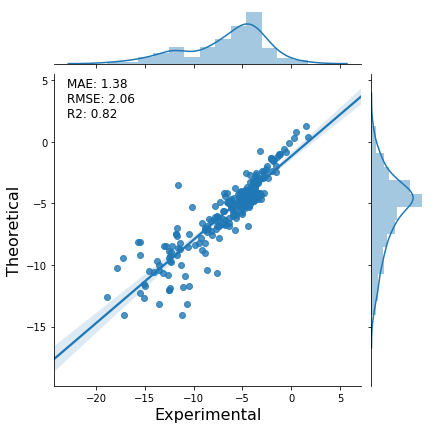

In [186]:
#fig, ax = plt.subplots()
j = sns.jointplot('Sol', 'CalcSol', data=compare_use, kind="reg")
j.set_axis_labels('Experimental', 'Theoretical', fontsize=16)
plt.text(-23,2, "R2: 0.82", fontsize = 12, color='Black')
plt.text(-23,3.2, "RMSE: 2.06", fontsize = 12, color='Black')
plt.text(-23,4.4, "MAE: 1.38", fontsize = 12, color='Black')

#j.annotate(r2)
#plt.annotate('Something', xy=(0.05, 0.05), xycoords='axes fraction')
#plt.legend()
#j.ax_joint.collections[0].set_alpha(0)
#plt.text('r2')
#plt.tight_layout()
#plt.show()
j.savefig('./solvation_summary/expCalc_Minnesota.svg', format='svg', dpi=1200)